In [1]:


# Notebook for running currentscape.
# Run your model first, then run currentscape.
# One sticking point I found is that if you don't specify your current_names, it will automatically label them with their currents in sim_config > 'currents'.
# However, the colors may not line up between 2 conditions (Eg. WT vs HET) since they will be ordered based on percentage of current contribution.
# Some more info https://currentscape.readthedocs.io/en/latest/tutorial.html

from NeuronModelClass import NeuronModel
from NrnHelper import *
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import numpy as np
from currentscape.currentscape import plot_currentscape

%matplotlib inline
 

class Na12Model_TF:
    def __init__(self,na12name = 'na12_HMM_TF100923',mut_name= 'mut2_2_na12hmm120523',  na12mechs = ['na12','na12mut'],na16name = 'na16_orig2', na16mechs = ['na16','na16mut'], params_folder = './params/na12HMM_HOF_params/',
                 nav12=1,nav16=1,K=1,KT=1,KP=1,somaK=1,ais_ca = 1,ais_Kca = 1,soma_na16=1,soma_na12 = 1,node_na = 1,plots_folder = './Plots/12HMM16HH_TF/TEST_121223/',pfx='testprefix'):
        
        ##Some params I found to work well, your model may need modifications 
        nav16 = 2.1
        nav12 = 0.25       
        K = 4
        node_na = 100
        
                
        self.l5mdl = NeuronModel(nav12=nav12, nav16=nav16,axon_K = K,axon_Kp = KP,axon_Kt = KT,soma_K = somaK,ais_ca = ais_ca,ais_KCa=ais_Kca,soma_nav16=soma_na16,soma_nav12 = soma_na12,node_na = node_na)
        update_param_value(self.l5mdl,['SKv3_1'],'mtaumul',6)

          
        self.wt_mech = [na12mechs[0]] ##WT mechanism from class args.
        self.mut_mech = [na12mechs[1]] ##Can specify mutant mechanism, replace with WT mechanism in args if you want full WT, not het.   
        self.na16mechs = na16mechs
        self.plot_folder = plots_folder 
        self.plot_folder = f'{plots_folder}'
        Path(self.plot_folder).mkdir(parents=True, exist_ok=True)
        self.pfx = pfx

        self.l5mdl.h.working()                                                  
        p_fn_na12 = f'{params_folder}{na12name}.txt'  
        p_fn_na12_mech = f'{params_folder}{mut_name}.txt'
        print(f'using wt_file {na12name}')
        self.na12_p = update_mech_from_dict(self.l5mdl, p_fn_na12, self.wt_mech) ##Update default WT mechanism parameters with the ones we give
        print(eval("h.psection()")) ##For debug/double check that my mech was updated.
        print(f'using mut_file {mut_name}')
        self.na12_pmech = update_mech_from_dict(self.l5mdl, p_fn_na12_mech, self.mut_mech) ##Update default MUT mechanism parameters with the ones we give
        print(eval("h.psection()")) ##For debug/double check that my mech was updated.
        
    
    def make_currentscape_plot(self,amp,time1,time2,stim_start =100,sweep_len=800,sim_config = {
                'section' : 'soma',
                'segment' : 0.5, ##0.5 should be half way down AIS
                'section_num': 0,
                'currents'  : ['ihcn_Ih','ica_Ca_HVA','ica_Ca_LVAst','ik_SKv3_1','ik_SK_E2','na16.ina_ina','na16mut.ina_ina','na12.ina_ina','na12mut.ina_ina','i_pas'], ##Currents must be present in .mod files
                #'currents'  :['ina','ica','ik'], ##Example if you have fewer currents
                'ionic_concentrations' :["cai", "ki", "nai"]
        }):
        
        current_names = ['Ih','Ca_HVA','Ca_LVAst','SKv3_1','SK_E2','Na16 WT','Na16 WT','Na12','Na12 MUT','pas'] ##Current names in order of 'currents'in sim_config. Or if you don't want different curent names, use- current_names = sim_config['currents']

        
        #amp = 0.5 ##Modify stimulus current
        #sweep_len = 800 ##Modify this to change total length of recording
        self.l5mdl.init_stim(stim_start =stim_start,amp=amp,sweep_len = sweep_len) ##Modify stim_start to change with the stimulus starts. Helpful when looking at single APs
        Vm, I, t, stim, ionic = self.l5mdl.run_sim_model(dt=0.01,sim_config=sim_config) ##un the model, dt is timesteps

        
        ##### Below for plotting user-specified time steps
        dt = 0.01 ##dt used for calculating time steps
        # time1 = 51 ##start time. Must be between 0 < x < sweep_len
        # time2 = 60 ##end time. Must be between 0 < x < sweep_len
        step1 = int((time1/dt))
        step2 = int((time2/dt))
        Vmsteplist = Vm[step1:step2] ##assign new list for range selected between two steps
        maxvm = max(Vm[step1:step2]) ##gets max voltage
        indexmax = Vmsteplist.argmax() ##gets index (time point in Vmsteplist) where max voltage is
        #####

        
        plot_config = {
            "output": {
                "savefig": True,
                #"dir": "./Plots/12HMM16HH_TF/SynthMuts_120523/Currentscape/", ##can hardcode output directory path
                "dir": f"{self.plot_folder}",
                #"fname": "Na12_mut22_1nA_800ms", ##Change file name here
                "fname":f"{self.pfx}_{amp}_{sweep_len}",
                "extension": "pdf", ##choose pdf or other image extension
                #"extension": "jpg",
                "dpi": 600,
                "transparent": False},

            "show":{#"total_contribution":True, ##adds pie charts for overall contribution of currents over full recording
                    #"all_currents":True, ##adds line plots below currents to to show currents over time (rather than just percentage of total)
                    "currentscape": True}, ##Shows currentscape

            "colormap": {"name":"colorbrewer.qualitative.Paired_10"}, ##Can change color pallets. The _# means how many colors in that pallette. If you don't have enough colors for each current to have unique color, some currents will not be displayed
            #"colormap": {"name":"cartocolors.qualitative.Prism_10"},
            #"colormap": {"name":"cmocean.diverging.Balance_10"},
            
            "xaxis":{"xticks":[25,50,75],
                     "gridline_width":0.2,},

            "current": {"names": current_names,
                        "reorder":False,
                        # "autoscale_ticks_and_ylim":False,
                        # "ticks":[0.00001, 0.001, 0.1], 
                        # "ylim":[0.00001,0.01] #yaxis lims[min,max]
                        },

            "ions":{"names": ["ca", "k", "na"], ##Ionic currents to be displayed at bottom of plot
                    "reorder": False},

            "voltage": {"ylim": [-90, 50]},
            "legendtextsize": 5,
            "adjust": {
                "left": 0.15,
                "right": 0.8,
                "top": 1.0,
                "bottom": 0.0
                }
            }
        
       
        print(f"The max voltage value is {maxvm}")        
        print(f"The index at which the max voltage happens is {indexmax}")
        
        #fig = plot_currentscape(Vm, [I[x] for x in I.keys()], plot_config,[ionic[x] for x in ionic.keys()]) ##Default version that plots full sweep_len (full simulation)
        fig = plot_currentscape(Vm[step1:step2], [I[x][step1:step2] for x in I.keys()], plot_config,[ionic[x][step1:step2] for x in ionic.keys()]) ##Use this version to add time steps, must include time1 and time2 above
        #fig = plot_currentscape(Vm[step1:step2], [I[x][step1:step2] for x in I.keys()], plot_config) ##Plots time step version but removes ionic currents plot at bottom

        

        
        ###### Writing all raw data to csv######
        # with open("./Plots/12HH16HMM_TF/111423/Currentscape/Na16_WT_1na_75ms_rawdata.csv",'w',newline ='') as csvfile:
        #     writer = csv.writer(csvfile, delimiter = ',')
        #     #writer.writerow(current_names)
        #     writer.writerow(I.keys())
            
        #     writer.writerows(I[x] for x in I) ##This and line below for writing data from entire sweep_len
        #     writer.writerow(Vm)
            
            # writer.writerows(I[x][step1:step2] for x in I) ##This and below line are used when time steps are used
            # writer.writerow(Vm[step1:step2])
        
        

        

--No graphics will be displayed.


running model at /global/u2/t/tfenton/Neuron_general-2/Neuron_Model_12HMM16HH run dir is /global/u2/t/tfenton/Neuron_general-2
There is 2.1 of WT nav16
There is 0.25 of WT nav12
	1 
	1 
Setting temperature to 34.000000 C
Setting simulation time step to 0.100000 ms
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
ran working
	1 
	1 
	1 
**********************
cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0]
1 
1 
1 
	1 
ran working
ran working
	1 
	1 
ran working
cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[0].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].axon[0].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[114].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[1].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].axon[1].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[122].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[115].mtaumul_SKv3_1 = 6
cADpyr232_L5_TTPC1_0fb1ca4724[0].apic[3].mtaumul_SKv3_1 = 6
cADp

The max voltage value is 26.86403082422719
The index at which the max voltage happens is 6027


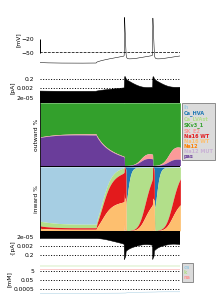

In [2]:
## I normally create an instance of my model and do the plotting in a separate file/jupyter notebook but as an example...

sim = Na12Model_TF(na12name = 'na12_HMM_TF100923',mut_name = 'na12_HMM_TF100923',
                  params_folder = './params/na12HMM_HOF_params/',
                  plots_folder = '/global/homes/t/tfenton/Neuron_general-2/Plots/12HMM16HH_TF/WT_Kyung/', pfx='WT_')

sim.make_currentscape_plot(amp=0.5, time1=0,time2=100,stim_start=40, sweep_len=100)
plt.show()
